# test2: 测试几种正则化方法

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model
import scipy.io
import h5py

In [2]:

def sigmoid(x):
    s = 1/(1+np.exp(-x))
    
    return s

In [3]:
def relu(x):
    s = np.maximum(0,x)
    
    return s

In [4]:
def initialize_parameters(layer_dims):
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims) # number of layers in the network

    for l in range(1, L):
        parameters[f'W{str(l)}'] = np.random.randn(layer_dims[l], layer_dims[l - 1]) / np.sqrt(layer_dims[l - 1])
        parameters[f'b{str(l)}'] = np.zeros((layer_dims[l], 1))

    return parameters

In [5]:
def plot_decision_boundary(model, X, y):

    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
    plt.show()

In [6]:
def load_2D_dataset():
    data = scipy.io.loadmat('datasets/data.mat')
    train_X = data['X'].T
    train_Y = data['y'].T
    test_X = data['Xval'].T
    test_Y = data['yval'].T

    plt.scatter(train_X[0, :], train_X[1, :], c=np.squeeze(train_Y), s=40, cmap=plt.cm.Spectral)
    
    return train_X, train_Y, test_X, test_Y

In [7]:
def forward_propagation(X, parameters):
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]

    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = relu(Z2)
    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3)
    
    cache = (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3)
    
    return A3, cache

In [8]:
def backward_propagation(X, Y, cache):
    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = 1./m * np.dot(dZ3, A2.T)
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)
    
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2, A1.T)
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
    
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T)
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,
                 "dA2": dA2, "dZ2": dZ2, "dW2": dW2, "db2": db2,
                 "dA1": dA1, "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

In [9]:
def update_parameters(parameters, grads, learning_rate):
    n = len(parameters) // 2

    for k in range(n):
        parameters[f"W{str(k+1)}"] = parameters[f"W{str(k+1)}"] - learning_rate * grads[f"dW{str(k+1)}"]
        parameters[f"b{str(k+1)}"] = parameters[f"b{str(k+1)}"] - learning_rate * grads[f"db{str(k+1)}"]

    return parameters

In [10]:
def predict(X, y, parameters):
    m = X.shape[1]
    p = np.zeros((1,m), dtype = np.int)

    a3, caches = forward_propagation(X, parameters)

    for i in range(a3.shape[1]):
        p[0,i] = 1 if a3[0,i] > 0.5 else 0
        
    print(f"Accuracy: {str(np.mean((p[0,:] == y[0,:])))}")

    return p

In [11]:
def compute_cost(a3, Y):
    m = Y.shape[1]
    
    logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)
    cost = 1./m * np.nansum(logprobs)
    
    return cost


In [12]:
def predict_dec(parameters, X):
    a3, cache = forward_propagation(X, parameters)
    predictions = (a3 > 0.5)

    return predictions

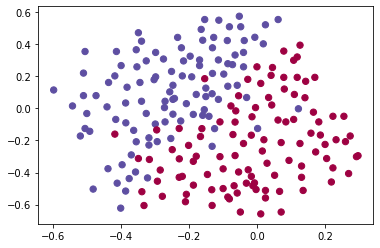

In [13]:
train_X, train_Y, test_X, test_Y = load_2D_dataset()

In [14]:
def compute_cost_with_regularization(A3, Y, parameters, lambd):
    m = Y.shape[1]
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]

    cross_entropy_cost = compute_cost(A3, Y)
    L2_regularization_cost = 1/m * lambd/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)) + np.sum(np.square(W3)))
    cost = cross_entropy_cost + L2_regularization_cost

    return cost

In [15]:
def backward_propagation_with_regularization(X, Y, cache, lambd):
    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache

    dZ3 = A3 - Y
    dW3 = 1./m * np.dot(dZ3, A2.T) + lambd/m * W3
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims=True)
    
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2, A1.T) + lambd/m * W2
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
    
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T) + lambd/m * W1
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

In [16]:
def forward_propagation_with_dropout(X, parameters, keep_prob = 0.5):
    np.random.seed(1)
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
    D1 = np.random.rand(A1.shape[0], A1.shape[1])
    D1 = D1 < keep_prob
    A1 = np.multiply(D1, A1)
    A1 = A1 / keep_prob

    Z2 = np.dot(W2, A1) + b2
    A2 = relu(Z2)
    D2 = np.random.rand(A2.shape[0], A2.shape[1])
    D2 = D2 < keep_prob
    A2 = np.multiply(D2, A2)
    A2 = A2 / keep_prob

    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3)

    cache = (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3)
    
    return A3, cache    

In [17]:
def backward_propagation_with_dropout(X, Y, cache, keep_prob):

    m = X.shape[1]
    (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = 1./m * np.dot(dZ3, A2.T)
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)
    
    dA2 = np.dot(W3.T, dZ3)
    dA2 = np.multiply(dA2, D2)
    dA2 = dA2 / keep_prob
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2, A1.T)
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
    
    dA1 = np.dot(W2.T, dZ2)
    dA1 = np.multiply(dA1, D1)
    dA1 = dA1 / keep_prob
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T)
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

In [18]:
def model(X, Y, learning_rate=0.3, num_iterations=30000, print_cost=True, lambd=0, keep_prob=1):
    grads = {}
    costs = []
    m = X.shape[1]
    layers_dims= [X.shape[0], 20, 3, 1]

    parameters = initialize_parameters(layers_dims)
    
    for i in range(num_iterations):
        if keep_prob == 1:
            a3, cache = forward_propagation(X, parameters)
        elif keep_prob < 1:
            a3, cache = forward_propagation_with_dropout(X, parameters, keep_prob)
        if lambd == 0:
            cost = compute_cost(a3, Y)
        else:
            cost = compute_cost_with_regularization(a3, Y, parameters, lambd)

        assert(lambd==0 or keep_prob==1)

        if lambd == 0 and keep_prob == 1:
            grads = backward_propagation(X, Y, cache)
        elif lambd != 0:
            grads = backward_propagation_with_regularization(X, Y, cache, lambd)
        elif keep_prob < 1:
            grads = backward_propagation_with_dropout(X, Y, cache, keep_prob)

        parameters = update_parameters(parameters, grads, learning_rate)

        if print_cost and i % 10000 == 0:
            print(f"Cost after iteration {i}: {cost}")
        if print_cost and i % 1000 == 0:
            costs.append(cost)

    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (x1,000)')
    plt.title(f"Learning rate ={str(learning_rate)}")
    plt.show()

    return parameters

Cost after iteration 0: 0.6557412523481002
Cost after iteration 10000: 0.16329987525724213
Cost after iteration 20000: 0.13851642423245572


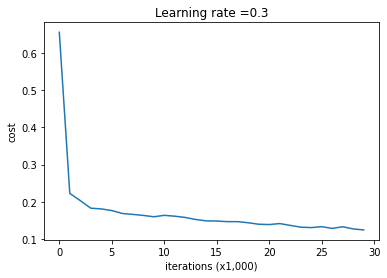

On the training set:
Accuracy: 0.9478672985781991
On the test set:
Accuracy: 0.915


d:\Program Files\Python\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
parameters = model(train_X, train_Y)
print ("On the training set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

Cost after iteration 0: 0.6974484493131264
Cost after iteration 10000: 0.26849188732822393
Cost after iteration 20000: 0.2680916337127301


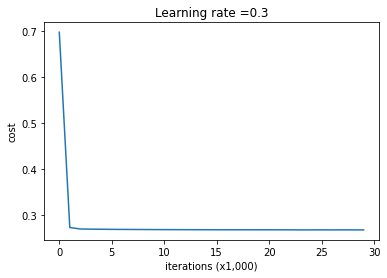

On the train set:
Accuracy: 0.9383886255924171
On the test set:
Accuracy: 0.93


d:\Program Files\Python\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


In [20]:
parameters = model(train_X, train_Y, lambd = 0.7)
print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

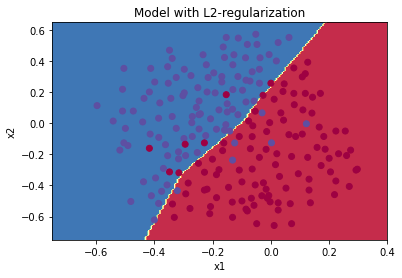

In [21]:
plt.title("Model with L2-regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y.ravel())

Cost after iteration 0: 0.6543912405149825
Cost after iteration 10000: 0.07117062095849112


d:\Program Files\Python\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
d:\Program Files\Python\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.


Cost after iteration 20000: 0.06215243913462137


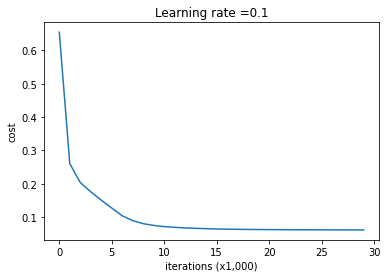

On the train set:
Accuracy: 0.933649289099526
On the test set:
Accuracy: 0.95


d:\Program Files\Python\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


In [22]:
parameters = model(train_X, train_Y, keep_prob = 0.86, learning_rate = 0.1)

print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

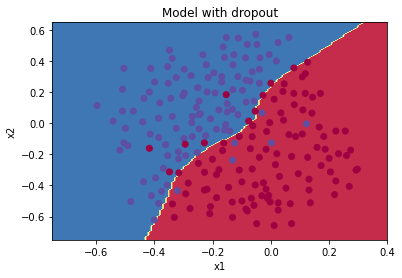

In [23]:
plt.title("Model with dropout")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y.ravel())